# Resultados Sotavento

! Nota: En este análisis no haremos evaluaciones de los modelos, puesto que estas van implícitas en los scripts referentes al problema de sotavento !

## Importación de recursos

In [1]:
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2

import random as python_random
from numpy.random import seed
from tensorflow.random import set_seed

import os
import sys
import time
import pickle
import gzip

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pandas

import tensorflow 
from tensorflow import keras

import keras.losses
from keras.models import Model
from keras.layers import Input,Dense
from keras import regularizers
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.initializers import glorot_uniform
from keras.regularizers import L2

from sklearn.datasets import load_boston
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, make_scorer, mean_absolute_error

import scikeras
from scikeras.wrappers import KerasClassifier, BaseWrapper
from joblib import dump, load
from basewrapper import BaseWrapper

import matplotlib.pyplot as plt
import seaborn as sns

from joblib import load


## Definición de métodos para el análisis de resultados

In [2]:

def rejilla(dataset):
    coordenadas = ["(43.625, -8.125)","(43.625, -8.0)","(43.625, -7.875)","(43.625, -7.75)","(43.625, -7.625)",
               "(43.5, -8.125)","(43.5, -8.0)","(43.5, -7.875)","(43.5, -7.75)","(43.5, -7.625)",
               "(43.375, -8.125)","(43.375, -8.0)","(43.375, -7.875)","(43.375, -7.75)","(43.375, -7.625)",
               "(43.25, -8.125)","(43.25, -8.0)","(43.25, -7.875)","(43.25, -7.75)","(43.25, -7.625)",
               "(43.125, -8.125)","(43.125, -8.0)","(43.125, -7.875)","(43.125, -7.75)","(43.125, -7.625)"]
    variables = ["10u_", "10v_", "2t_", "sp_", "100u_", "100v_", "vel10_", "vel100_"]
    
    indices = []
    for var in variables:
        for coord in coordenadas:
            indices.append(str(var) + str(coord))
    return(dataset[indices])

def sotavento_data():
    sota2016 = pd.read_csv("data/data_target_stv_2016.csv", sep = ',',  encoding = "ISO-8859-1", index_col=0, parse_dates=True).dropna()
    sota2017 = pd.read_csv("data/data_target_stv_2017.csv", sep = ',',  encoding = "ISO-8859-1", index_col=0, parse_dates=True).dropna()
    test = pd.read_csv("data/data_target_stv_2018.csv", sep = ',',  encoding = "ISO-8859-1", index_col=0, parse_dates=True).dropna()
    train = sota2016.append(sota2017)
    y_train = train[['targ']].to_numpy()
    x_train = rejilla(train.drop(columns = ['targ'])).to_numpy()
    y_test = test[['targ']].to_numpy()
    x_test = rejilla(test.drop(columns = ['targ'])).to_numpy()
    return(x_train,y_train,x_test,y_test)

def set_seed(seed):

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    os.environ['PYTHONHASHSEED'] = str(seed)
    python_random.seed(seed)
    tensorflow.random.set_seed(seed)
    np.random.seed(seed)

def network(l2):
    """
    Builds functional MLP Keras model for companion categorical_crossentropy and mse losses,
    softmax and linear outputs respectively, relu activations, adam solver.
    
    ### Arguments:
        input_shape: feature dimension
        output_shape: target dimension
        hidden_layer_sizes: list with number of units on hidden layers
        regr_loss: regression loss; mse or mean_absolute_error
        alpha: parameter for l2 kernel regularizers for all layers
        
    ### Returns:
        model: Model
    """
    set_seed(123)
    input_layer = Input(shape=(200,),name = "input_layer")
    layer_1 = Dense(200, activation="relu", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'layer_1')(input_layer)
    layer_2 = Dense(100, activation="relu", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'layer_2')(layer_1)
    output_layer = Dense(1, activation="linear", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'output_layer')(layer_2)
    ##Defining the model by specifying the input and output layers
    model = Model(inputs=input_layer, outputs=output_layer)
    ## defining the optimiser and loss function
    model.compile(optimizer='adam', loss='mse', metrics = 'mae')
    return model


def fc_mae(y, y_pred, **kwargs):
    return -mean_absolute_error(y, y_pred) 

class CompanionWrapper(BaseWrapper):
    """
    Predictions made on the RR outputs.
    """
        
    def __init__(self, model = network, **sk_params):
        BaseWrapper.__init__(self, model=model, **sk_params)
    

    def fit(self, x, y, **kwargs):
    	  
        
        """
        Assumes class codings as consecutive labels 0, 1, ...
        """    
        es = keras.callbacks.EarlyStopping(monitor="loss",
                                        min_delta=1.e-8,
                                        patience=50,
                                        verbose=0,
                                        mode="auto",
                                        baseline=None,
                                        restore_best_weights=True,
    
        )
	  
        y_regr = y
        
        self.X_dtype_ = type(x)
        self.X_shape_ = x.shape


        self.history_ = BaseWrapper.fit(self, x, {'output_layer':y_regr},
                                        epochs = self.epochs, initial_epoch = 0, shuffle = False,
                                       callbacks = [es])

        return self.history_

    # Convertir la salida a rango [5,50] respetando el contexto.
    def predict(self, x, **kwargs):
        """
        We just drop the mse predictions of the model and keep the CE ones
        in the first returned list.
        """
        pred = BaseWrapper.predict(self, x)
        return np.clip(pred, a_min = 0, a_max = 1)
    
    def score(self, x, y):
        y_pred = BaseWrapper.predict(self, x)
        y_pred = np.clip(y_pred, a_min = 0, a_max = 1)
        return mean_absolute_error(y, y_pred)


# Modelo mse

## Ajuste de hiperparámetros

best_alpha = 0.10000
best_cv_mae = 0.075


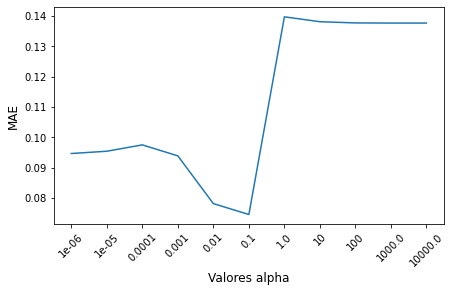

In [3]:
python_random.seed(123) 
set_seed(123)
seed(123) 

regr = load('regr_wrap.joblib')
plt.figure(figsize=(7, 4))
l_alpha = [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1.0, 10, 100, 1e+3, 1e+4, 1e+5]
print('best_alpha = %.5f' % regr.best_params_['regressor__mlp__l2'])
print('best_cv_mae = %.3f' % (-regr.best_score_))
plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
plt.xlabel('Valores alpha', fontsize=12)
plt.ylabel("MAE", fontsize=12)
plt.plot(-regr.cv_results_['mean_test_score'])
plt.savefig('regr_param.png', bbox_inches = 'tight')
plt.show()


# Modelo mse + ec

## Escenario K=3

In [4]:

def rejilla(dataset):
    coordenadas = ["(43.625, -8.125)","(43.625, -8.0)","(43.625, -7.875)","(43.625, -7.75)","(43.625, -7.625)",
               "(43.5, -8.125)","(43.5, -8.0)","(43.5, -7.875)","(43.5, -7.75)","(43.5, -7.625)",
               "(43.375, -8.125)","(43.375, -8.0)","(43.375, -7.875)","(43.375, -7.75)","(43.375, -7.625)",
               "(43.25, -8.125)","(43.25, -8.0)","(43.25, -7.875)","(43.25, -7.75)","(43.25, -7.625)",
               "(43.125, -8.125)","(43.125, -8.0)","(43.125, -7.875)","(43.125, -7.75)","(43.125, -7.625)"]
    variables = ["10u_", "10v_", "2t_", "sp_", "100u_", "100v_", "vel10_", "vel100_"]
    
    indices = []
    for var in variables:
        for coord in coordenadas:
            indices.append(str(var) + str(coord))
    return(dataset[indices])

def sotavento_data():
    sota2016 = pd.read_csv("data/data_target_stv_2016.csv", sep = ',',  encoding = "ISO-8859-1", index_col=0, parse_dates=True).dropna()
    sota2017 = pd.read_csv("data/data_target_stv_2017.csv", sep = ',',  encoding = "ISO-8859-1", index_col=0, parse_dates=True).dropna()
    test = pd.read_csv("data/data_target_stv_2018.csv", sep = ',',  encoding = "ISO-8859-1", index_col=0, parse_dates=True).dropna()
    train = sota2016.append(sota2017)
    y_train = train[['targ']].to_numpy()
    x_train = rejilla(train.drop(columns = ['targ'])).to_numpy()
    y_test = test[['targ']].to_numpy()
    x_test = rejilla(test.drop(columns = ['targ'])).to_numpy()
    return(x_train,y_train,x_test,y_test)


def set_seed(seed):

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    os.environ['PYTHONHASHSEED'] = str(seed)
    python_random.seed(seed)
    tensorflow.random.set_seed(seed)
    np.random.seed(seed)


def network(l2, lw):
    """
    Builds functional MLP Keras model for companion categorical_crossentropy and mse losses,
    softmax and linear outputs respectively, relu activations, adam solver.
    
    ### Arguments:
        input_shape: feature dimension
        output_shape: target dimension
        hidden_layer_sizes: list with number of units on hidden layers
        regr_loss: regression loss; mse or mean_absolute_error
        alpha: parameter for l2 kernel regularizers for all layers
        
    ### Returns:
        model: Model
    """
    set_seed(123)
    input_layer = Input(shape=(200,),name = "input_layer")
    layer_1 = Dense(200, activation="relu", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'layer_1')(input_layer)
    layer_2 = Dense(100, activation="relu", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'layer_2')(layer_1)
    regr_layer = Dense(1, activation="linear", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'regr_layer')(layer_2)
    clas_layer = Dense(3, activation="softmax", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'clas_layer')(layer_2)
    ##Defining the model by specifying the input and output layers
    network_ = Model(inputs=[input_layer], outputs=[regr_layer, clas_layer])
    ## defining the optimiser and loss function
    network_.compile(optimizer='adam',
                   loss={'regr_layer':'mse','clas_layer': 'categorical_crossentropy'},
                   loss_weights= {"regr_layer":1.0, "clas_layer": lw},
                   metrics = {'regr_layer':'mae', "clas_layer": 'accuracy'})
    return(network_)

class PartialMinMaxScaler(MinMaxScaler):
    """Applies the scaler in super() to the first column of the 
    numpy array to be scaled,
    """
    def fit(self, x):
        super().fit(x[ : , 0].reshape(-1, 1))
        
    def transform(self, x):
        xx = x.copy()
        xx_0 = super().transform(x[ : , 0].reshape(-1, 1))
        xx[ : , 0] = xx_0.reshape(-1, )
        return xx
        
    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)
    def inverse_transform(self, x):
        xx = x.copy()
        x_0 = super().inverse_transform(x[ : , 0].reshape(-1, 1))
        xx[ : , 0] = x_0.reshape(-1, )
        return xx

def fc_mae(y, y_pred, **kwargs):
    return -mean_absolute_error(y[ : , 0], y_pred) 

class CompanionWrapper(BaseWrapper):
    """
    Predictions made on the RR outputs.
    """
    def __init__(self, model = network, **sk_params):
        BaseWrapper.__init__(self, model=model, **sk_params)
    def fit(self, x, y, **kwargs):
        """
        Assumes class codings as consecutive labels 0, 1, ...
        """        
        es = keras.callbacks.EarlyStopping(monitor="loss",
                                            min_delta=1.e-8,
                                            patience=50,
                                            verbose=0,
                                            mode="auto",
                                            baseline=None,
                                            restore_best_weights=True,
                                            )
        
        y_regr = y[:,0]
        y_clas = y[:,1]
        onehot = to_categorical(y_clas)
        
        self.X_dtype_ = type(x)
        self.X_shape_ = x.shape
        
        self.history_ = BaseWrapper.fit(self, x,
                                        {'regr_layer':y_regr,'clas_layer':onehot},
                                        epochs = self.epochs, initial_epoch = 0, shuffle=False,
                                        callbacks = [es])

        return self.history_

    # Convertir la salida a rango [0,1] respetando el contexto.
    def predict(self, x, **kwargs):
        """
        We just drop the mse predictions of the model and keep the CE ones
        in the first returned list.
        """
        pred = BaseWrapper.predict(self, x)[0]
        return np.clip(pred, a_min = 0, a_max = 1)
    
    def score(self, x, y):
        y_pred = BaseWrapper.predict(self, x)[0]
        y_pred = np.clip(y_pred, a_min = 0, a_max = 1)
        return mean_absolute_error(y[:,0], y_pred)


## Ajuste de hiperparámetros

In [5]:
python_random.seed(123) 
set_seed(123)
seed(123) 

comp1_K3 = load('comp_wrap_K3.joblib')

In [6]:
lw0 = []
lw1 = []
lw2 = []
lw3 = []
lw4 = []
lw5 = []
lw6 = []
lw7 = []
lw8 = []
lw9 = []
lw10 = []
lw11 = []
lw12 = []
lw13 = []
lw14 = []
lw15 = []
lw16 = []
lw17 = []
lw18 = []
lw19 = []
for i in range(0,220):
    if i % 20==0:
        lw0.append(i)
    elif i % 20==1:
        lw1.append(i)
    elif i % 20==2:
        lw2.append(i)
    elif i % 20==3:
        lw3.append(i)
    elif i % 20==4:
        lw4.append(i)
    elif i % 20==5:
        lw5.append(i)
    elif i % 20==6:
        lw6.append(i)
    elif i % 20==7:
        lw7.append(i)
    elif i % 20==8:
        lw8.append(i)
    elif i % 20==9:
        lw9.append(i)
    if i % 20==10:
        lw10.append(i)
    elif i % 20==11:
        lw11.append(i)
    elif i % 20==12:
        lw12.append(i)
    elif i % 20==13:
        lw13.append(i)
    elif i % 20==14:
        lw14.append(i)
    elif i % 20==15:
        lw15.append(i)
    elif i % 20==16:
        lw16.append(i)
    elif i % 20==17:
        lw17.append(i)
    elif i % 20==18:
        lw18.append(i)
    elif i % 20==19:
        lw19.append(i)
        
res0 = comp1_K3.cv_results_['mean_test_score'][lw0]
res1 = comp1_K3.cv_results_['mean_test_score'][lw1]
res2 = comp1_K3.cv_results_['mean_test_score'][lw2]
res3 = comp1_K3.cv_results_['mean_test_score'][lw3]
res4 = comp1_K3.cv_results_['mean_test_score'][lw4]
res5 = comp1_K3.cv_results_['mean_test_score'][lw5]
res6 = comp1_K3.cv_results_['mean_test_score'][lw6]
res7 = comp1_K3.cv_results_['mean_test_score'][lw7]
res8 = comp1_K3.cv_results_['mean_test_score'][lw8]
res9 = comp1_K3.cv_results_['mean_test_score'][lw9]
res10 = comp1_K3.cv_results_['mean_test_score'][lw10]
res11 = comp1_K3.cv_results_['mean_test_score'][lw11]
res12 = comp1_K3.cv_results_['mean_test_score'][lw12]
res13 = comp1_K3.cv_results_['mean_test_score'][lw13]
res14 = comp1_K3.cv_results_['mean_test_score'][lw14]
res15 = comp1_K3.cv_results_['mean_test_score'][lw15]
res16 = comp1_K3.cv_results_['mean_test_score'][lw16]
res17 = comp1_K3.cv_results_['mean_test_score'][lw17]
res18 = comp1_K3.cv_results_['mean_test_score'][lw18]
res19 = comp1_K3.cv_results_['mean_test_score'][lw19]


best_alpha = 0.0010
best_lw = 0.1500
best_cv_mae = -0.059


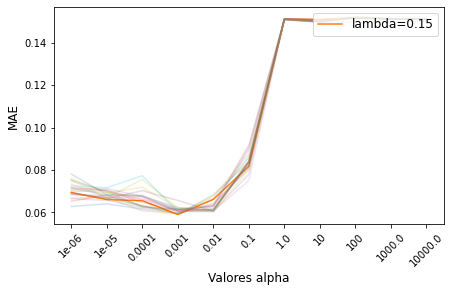

In [7]:
l_alpha = [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1.0, 10, 100, 1e+3, 1e+4, 1e+5]
res0 = comp1_K3.cv_results_['mean_test_score'][lw0]
plt.figure( figsize=(7,4))
print('best_alpha = %.4f' % comp1_K3.best_params_['regressor__mlp__l2'])
print('best_lw = %.4f' % comp1_K3.best_params_['regressor__mlp__lw'])
print('best_cv_mae = %.3f' % (comp1_K3.best_score_))
plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
plt.xlabel('Valores alpha', fontsize=12)
plt.ylabel("MAE", fontsize=12)
plt.plot(-res0, alpha=0.2)
plt.plot(-res1, alpha=0.2)
plt.plot(-res2, alpha=0.2)
plt.plot(-res3, label = "lambda=0.15", color='C1')
plt.plot(-res4, alpha=0.2)
plt.plot(-res5, alpha=0.2)
plt.plot(-res6, alpha=0.2)
plt.plot(-res7, alpha=0.2)
plt.plot(-res8, alpha=0.2)
plt.plot(-res9, alpha=0.2)
plt.plot(-res10, alpha=0.2)
plt.plot(-res11, alpha=0.2)
plt.plot(-res12, alpha=0.2)
plt.plot(-res13, alpha=0.2)
plt.plot(-res14, alpha=0.2)
plt.plot(-res15, alpha=0.2)
plt.plot(-res16, alpha=0.2)
plt.plot(-res17, alpha=0.2)
plt.plot(-res18, alpha=0.2)
plt.plot(-res19, alpha=0.2)
plt.legend(loc=1, prop={'size': 12})
plt.savefig('comp1_wrap_K3_param.png', bbox_inches = 'tight')
plt.show()


## Escenario K=4 (modelo óptimo)

In [8]:

def rejilla(dataset):
    coordenadas = ["(43.625, -8.125)","(43.625, -8.0)","(43.625, -7.875)","(43.625, -7.75)","(43.625, -7.625)",
               "(43.5, -8.125)","(43.5, -8.0)","(43.5, -7.875)","(43.5, -7.75)","(43.5, -7.625)",
               "(43.375, -8.125)","(43.375, -8.0)","(43.375, -7.875)","(43.375, -7.75)","(43.375, -7.625)",
               "(43.25, -8.125)","(43.25, -8.0)","(43.25, -7.875)","(43.25, -7.75)","(43.25, -7.625)",
               "(43.125, -8.125)","(43.125, -8.0)","(43.125, -7.875)","(43.125, -7.75)","(43.125, -7.625)"]
    variables = ["10u_", "10v_", "2t_", "sp_", "100u_", "100v_", "vel10_", "vel100_"]
    
    indices = []
    for var in variables:
        for coord in coordenadas:
            indices.append(str(var) + str(coord))
    return(dataset[indices])

def sotavento_data():
    sota2016 = pd.read_csv("data/data_target_stv_2016.csv", sep = ',',  encoding = "ISO-8859-1", index_col=0, parse_dates=True).dropna()
    sota2017 = pd.read_csv("data/data_target_stv_2017.csv", sep = ',',  encoding = "ISO-8859-1", index_col=0, parse_dates=True).dropna()
    test = pd.read_csv("data/data_target_stv_2018.csv", sep = ',',  encoding = "ISO-8859-1", index_col=0, parse_dates=True).dropna()
    train = sota2016.append(sota2017)
    y_train = train[['targ']].to_numpy()
    x_train = rejilla(train.drop(columns = ['targ'])).to_numpy()
    y_test = test[['targ']].to_numpy()
    x_test = rejilla(test.drop(columns = ['targ'])).to_numpy()
    return(x_train,y_train,x_test,y_test)


def set_seed(seed):

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    os.environ['PYTHONHASHSEED'] = str(seed)
    python_random.seed(seed)
    tensorflow.random.set_seed(seed)
    np.random.seed(seed)


def network(l2, lw):
    """
    Builds functional MLP Keras model for companion categorical_crossentropy and mse losses,
    softmax and linear outputs respectively, relu activations, adam solver.
    
    ### Arguments:
        input_shape: feature dimension
        output_shape: target dimension
        hidden_layer_sizes: list with number of units on hidden layers
        regr_loss: regression loss; mse or mean_absolute_error
        alpha: parameter for l2 kernel regularizers for all layers
        
    ### Returns:
        model: Model
    """
    set_seed(123)
    input_layer = Input(shape=(200,),name = "input_layer")
    layer_1 = Dense(200, activation="relu", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'layer_1')(input_layer)
    layer_2 = Dense(100, activation="relu", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'layer_2')(layer_1)
    regr_layer = Dense(1, activation="linear", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'regr_layer')(layer_2)
    clas_layer = Dense(4, activation="softmax", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'clas_layer')(layer_2)
    ##Defining the model by specifying the input and output layers
    network_ = Model(inputs=[input_layer], outputs=[regr_layer, clas_layer])
    ## defining the optimiser and loss function
    network_.compile(optimizer='adam',
                   loss={'regr_layer':'mse','clas_layer': 'categorical_crossentropy'},
                   loss_weights= {"regr_layer":1.0, "clas_layer": lw},
                   metrics = {'regr_layer':'mae', "clas_layer": 'accuracy'})
    return(network_)

class PartialMinMaxScaler(MinMaxScaler):
    """Applies the scaler in super() to the first column of the 
    numpy array to be scaled,
    """
    def fit(self, x):
        super().fit(x[ : , 0].reshape(-1, 1))
        
    def transform(self, x):
        xx = x.copy()
        xx_0 = super().transform(x[ : , 0].reshape(-1, 1))
        xx[ : , 0] = xx_0.reshape(-1, )
        return xx
        
    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)
    def inverse_transform(self, x):
        xx = x.copy()
        x_0 = super().inverse_transform(x[ : , 0].reshape(-1, 1))
        xx[ : , 0] = x_0.reshape(-1, )
        return xx

def fc_mae(y, y_pred, **kwargs):
    return -mean_absolute_error(y[ : , 0], y_pred) 

class CompanionWrapper(BaseWrapper):
    """
    Predictions made on the RR outputs.
    """
    def __init__(self, model = network, **sk_params):
        BaseWrapper.__init__(self, model=model, **sk_params)
    def fit(self, x, y, **kwargs):
        """
        Assumes class codings as consecutive labels 0, 1, ...
        """        
        es = keras.callbacks.EarlyStopping(monitor="loss",
                                            min_delta=1.e-8,
                                            patience=50,
                                            verbose=0,
                                            mode="auto",
                                            baseline=None,
                                            restore_best_weights=True,
                                            )
        
        y_regr = y[:,0]
        y_clas = y[:,1]
        onehot = to_categorical(y_clas)
        
        self.X_dtype_ = type(x)
        self.X_shape_ = x.shape
        
        self.history_ = BaseWrapper.fit(self, x,
                                        {'regr_layer':y_regr,'clas_layer':onehot},
                                        epochs = self.epochs, initial_epoch = 0, shuffle=False,
                                       callbacks = [es])

        return self.history_

    # Convertir la salida a rango [0,1] respetando el contexto.
    def predict(self, x, **kwargs):
        """
        We just drop the mse predictions of the model and keep the CE ones
        in the first returned list.
        """
        pred = BaseWrapper.predict(self, x)[0]
        return np.clip(pred, a_min = 0, a_max = 1)
    
    def score(self, x, y):
        y_pred = BaseWrapper.predict(self, x)[0]
        y_pred = np.clip(y_pred, a_min = 0, a_max = 1)
        return mean_absolute_error(y[:,0], y_pred)


## Ajuste de hiperparámetros

In [9]:
python_random.seed(123) 
set_seed(123)
seed(123) 

comp1_K4 = load('comp_wrap_K4.joblib')

In [10]:
lw0 = []
lw1 = []
lw2 = []
lw3 = []
lw4 = []
lw5 = []
lw6 = []
lw7 = []
lw8 = []
lw9 = []
lw10 = []
lw11 = []
lw12 = []
lw13 = []
lw14 = []
lw15 = []
lw16 = []
lw17 = []
lw18 = []
lw19 = []
for i in range(0,220):
    if i % 20==0:
        lw0.append(i)
    elif i % 20==1:
        lw1.append(i)
    elif i % 20==2:
        lw2.append(i)
    elif i % 20==3:
        lw3.append(i)
    elif i % 20==4:
        lw4.append(i)
    elif i % 20==5:
        lw5.append(i)
    elif i % 20==6:
        lw6.append(i)
    elif i % 20==7:
        lw7.append(i)
    elif i % 20==8:
        lw8.append(i)
    elif i % 20==9:
        lw9.append(i)
    if i % 20==10:
        lw10.append(i)
    elif i % 20==11:
        lw11.append(i)
    elif i % 20==12:
        lw12.append(i)
    elif i % 20==13:
        lw13.append(i)
    elif i % 20==14:
        lw14.append(i)
    elif i % 20==15:
        lw15.append(i)
    elif i % 20==16:
        lw16.append(i)
    elif i % 20==17:
        lw17.append(i)
    elif i % 20==18:
        lw18.append(i)
    elif i % 20==19:
        lw19.append(i)
        
res0 = comp1_K4.cv_results_['mean_test_score'][lw0]
res1 = comp1_K4.cv_results_['mean_test_score'][lw1]
res2 = comp1_K4.cv_results_['mean_test_score'][lw2]
res3 = comp1_K4.cv_results_['mean_test_score'][lw3]
res4 = comp1_K4.cv_results_['mean_test_score'][lw4]
res5 = comp1_K4.cv_results_['mean_test_score'][lw5]
res6 = comp1_K4.cv_results_['mean_test_score'][lw6]
res7 = comp1_K4.cv_results_['mean_test_score'][lw7]
res8 = comp1_K4.cv_results_['mean_test_score'][lw8]
res9 = comp1_K4.cv_results_['mean_test_score'][lw9]
res10 = comp1_K4.cv_results_['mean_test_score'][lw10]
res11 = comp1_K4.cv_results_['mean_test_score'][lw11]
res12 = comp1_K4.cv_results_['mean_test_score'][lw12]
res13 = comp1_K4.cv_results_['mean_test_score'][lw13]
res14 = comp1_K4.cv_results_['mean_test_score'][lw14]
res15 = comp1_K4.cv_results_['mean_test_score'][lw15]
res16 = comp1_K4.cv_results_['mean_test_score'][lw16]
res17 = comp1_K4.cv_results_['mean_test_score'][lw17]
res18 = comp1_K4.cv_results_['mean_test_score'][lw18]
res19 = comp1_K4.cv_results_['mean_test_score'][lw19]


best_alpha = 0.0010
best_lw = 0.0500
best_cv_mae = -0.058


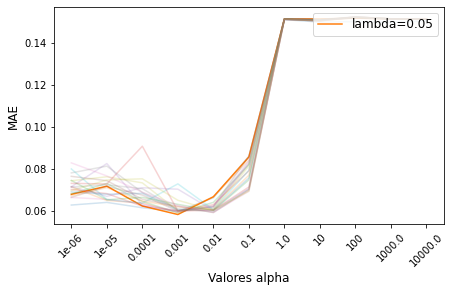

In [11]:
l_alpha = [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1.0, 10, 100, 1e+3, 1e+4, 1e+5]
res0 = comp1_K4.cv_results_['mean_test_score'][lw0]
plt.figure( figsize=(7,4))
print('best_alpha = %.4f' % comp1_K4.best_params_['regressor__mlp__l2'])
print('best_lw = %.4f' % comp1_K4.best_params_['regressor__mlp__lw'])
print('best_cv_mae = %.3f' % (comp1_K4.best_score_))
plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
plt.xlabel('Valores alpha', fontsize=12)
plt.ylabel("MAE", fontsize=12)
plt.plot(-res0, alpha=0.2)
plt.plot(-res1, label = "lambda=0.05", color='C1')
plt.plot(-res2, alpha=0.2)
plt.plot(-res3, alpha=0.2)
plt.plot(-res4, alpha=0.2)
plt.plot(-res5, alpha=0.2)
plt.plot(-res6, alpha=0.2)
plt.plot(-res7, alpha=0.2)
plt.plot(-res8, alpha=0.2)
plt.plot(-res9, alpha=0.2)
plt.plot(-res10, alpha=0.2)
plt.plot(-res11, alpha=0.2)
plt.plot(-res12, alpha=0.2)
plt.plot(-res13, alpha=0.2)
plt.plot(-res14, alpha=0.2)
plt.plot(-res15, alpha=0.2)
plt.plot(-res16, alpha=0.2)
plt.plot(-res17, alpha=0.2)
plt.plot(-res18, alpha=0.2)
plt.plot(-res19, alpha=0.2)
plt.legend(loc=1, prop={'size': 12})
plt.savefig('comp1_wrap_K4_param.png', bbox_inches = 'tight')
plt.show()


## Análisis de resultados del modelo óptimo

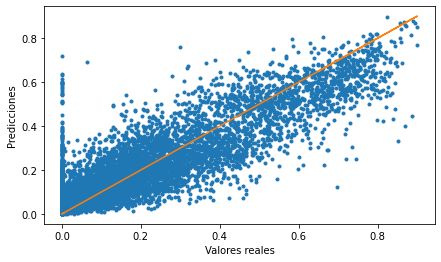

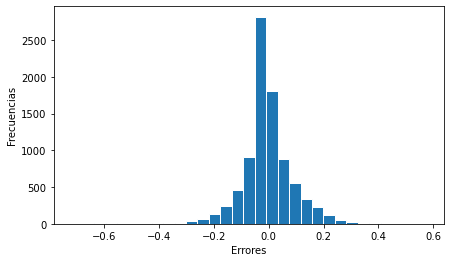

In [12]:
set_seed(123)
n_folds = 5
x_train,y_train,x_test,y_test = sotavento_data()
kf = KFold(n_folds, shuffle=True, random_state=123)
l_alpha = [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1.0, 10, 100, 1e+3, 1e+4, 1e+5]
clas_test = np.array(pd.cut(x=y_test.reshape(-1,), bins=[0.0, 0.2, 0.4, 0.6, 1.0], labels=[0, 1, 2, 3], include_lowest=True, right=True))
target_test = np.concatenate([y_test.reshape(-1,1),clas_test.reshape(-1,1)], axis = 1)
y_pred_mlp_cv = cross_val_predict(comp1_K4.best_estimator_, x_test, target_test, cv=kf)


plt.figure( figsize=(7,4))
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
_ = plt.plot(y_test, y_pred_mlp_cv, '.', y_test, y_test, '-')
plt.savefig('predi.png', bbox_inches = 'tight')
plt.show()

err = y_test.reshape(-1,) - y_pred_mlp_cv.reshape(-1,)
plt.figure( figsize=(7,4))
plt.xlabel("Errores")
plt.ylabel("Frecuencias")
_ = plt.hist(err, bins=31, ec = 'white')
plt.savefig('hist.png', bbox_inches = 'tight')
plt.show()

# Modelo mse + Fisher

## Escenario K=3

In [3]:
def rejilla(dataset):
    coordenadas = ["(43.625, -8.125)","(43.625, -8.0)","(43.625, -7.875)","(43.625, -7.75)","(43.625, -7.625)",
               "(43.5, -8.125)","(43.5, -8.0)","(43.5, -7.875)","(43.5, -7.75)","(43.5, -7.625)",
               "(43.375, -8.125)","(43.375, -8.0)","(43.375, -7.875)","(43.375, -7.75)","(43.375, -7.625)",
               "(43.25, -8.125)","(43.25, -8.0)","(43.25, -7.875)","(43.25, -7.75)","(43.25, -7.625)",
               "(43.125, -8.125)","(43.125, -8.0)","(43.125, -7.875)","(43.125, -7.75)","(43.125, -7.625)"]
    variables = ["10u_", "10v_", "2t_", "sp_", "100u_", "100v_", "vel10_", "vel100_"]
    
    indices = []
    for var in variables:
        for coord in coordenadas:
            indices.append(str(var) + str(coord))
    return(dataset[indices])
    
def fisher_y(y):
    """ y_ij = (n-n_j)/(n*sqrt(n_j)) if class(y_i)==j else -sqrt(n_j)/n """
    n = len(y)
    targets, counts = np.unique(y, return_counts=True)
    c = len(targets)
    lsrlda_y = np.zeros((n, c))
    for i, target in enumerate(y):
        t = targets.tolist().index(target)
        for j in range(c):
            if j==t:
                lsrlda_y[i, j] = (n - counts[t]) / (n * np.sqrt(counts[t]))
            else:
                lsrlda_y[i, j] = -np.sqrt(counts[t]/n)
    return lsrlda_y
    
def network(l2, lw):
    """
    Builds functional MLP Keras model for companion categorical_crossentropy and mse losses,
    softmax and linear outputs respectively, relu activations, adam solver.
    
    ### Arguments:
        input_shape: feature dimension
        output_shape: target dimension
        hidden_layer_sizes: list with number of units on hidden layers
        regr_loss: regression loss; mse or mean_absolute_error
        alpha: parameter for l2 kernel regularizers for all layers
        
    ### Returns:
        model: Model
    """
    set_seed(123)
    input_layer = Input(shape=(200,),name = "input_layer")
    layer_1 = Dense(200, activation="relu", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'layer_1')(input_layer)
    layer_2 = Dense(100, activation="relu", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'layer_2')(layer_1)
    regr_layer = Dense(1, activation="linear", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'regr_layer')(layer_2)
    clas_layer = Dense(3, activation="linear", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'clas_layer')(layer_2)
    ##Defining the model by specifying the input and output layers
    network_ = Model(inputs=[input_layer], outputs=[regr_layer, clas_layer])
    ## defining the optimiser and loss function
    network_.compile(optimizer='adam',
                   loss={'regr_layer':'mse','clas_layer': 'mse'},
                   loss_weights= {"regr_layer":1.0, "clas_layer": lw},
                   metrics = {'regr_layer':'mae', "clas_layer": 'accuracy'})
    return(network_)

class PartialMinMaxScaler(MinMaxScaler):
    """Applies the scaler in super() to the first column of the 
    numpy array to be scaled,
    """
    def fit(self, x):
        super().fit(x[ : , 0].reshape(-1, 1))
        
    def transform(self, x):
        xx = x.copy()
        xx_0 = super().transform(x[ : , 0].reshape(-1, 1))
        xx[ : , 0] = xx_0.reshape(-1, )
        return xx
        
    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)
    def inverse_transform(self, x):
        xx = x.copy()
        x_0 = super().inverse_transform(x[ : , 0].reshape(-1, 1))
        xx[ : , 0] = x_0.reshape(-1, )
        return xx

def fc_mae(y, y_pred, **kwargs):
    return -mean_absolute_error(y[ : , 0], y_pred) 

class CompanionWrapper(BaseWrapper):
    """
    Predictions made on the RR outputs.
    """
    def __init__(self, model = network, **sk_params):
        BaseWrapper.__init__(self, model=model, **sk_params)
    def fit(self, x, y, **kwargs):
        """
        Assumes class codings as consecutive labels 0, 1, ...
        """        
        es = keras.callbacks.EarlyStopping(monitor="loss",
                                            min_delta=1.e-8,
                                            patience=50,
                                            verbose=0,
                                            mode="auto",
                                            baseline=None,
                                            restore_best_weights=True,
                                            )
        
        y_regr = y[:,0]
        y_clas = y[:,1]
        fishery = fisher_y(y_clas)
        
        self.X_dtype_ = type(x)
        self.X_shape_ = x.shape
        
        self.history_ = BaseWrapper.fit(self, x,
                                        {'regr_layer':y_regr,'clas_layer':fishery},
                                        epochs = self.epochs, initial_epoch = 0, shuffle=False,
                                       callbacks = [es])

        return self.history_

    # Convertir la salida a rango [5,50.000] respetando el contexto.
    def predict(self, x, **kwargs):
        """
        We just drop the mse predictions of the model and keep the CE ones
        in the first returned list.
        """
        pred = BaseWrapper.predict(self, x)[0]
        return np.clip(pred, a_min = 0, a_max = 1)
    
    def score(self, x, y):
        y_pred = BaseWrapper.predict(self, x)[0]
        y_pred = np.clip(y_pred, a_min = 0, a_max = 1)
        return mean_absolute_error(y[:,0], y_pred)

def sotavento_data():
    sota2016 = pd.read_csv("data/data_target_stv_2016.csv", sep = ',',  encoding = "ISO-8859-1", index_col=0, parse_dates=True).dropna()
    sota2017 = pd.read_csv("data/data_target_stv_2017.csv", sep = ',',  encoding = "ISO-8859-1", index_col=0, parse_dates=True).dropna()
    test = pd.read_csv("data/data_target_stv_2018.csv", sep = ',',  encoding = "ISO-8859-1", index_col=0, parse_dates=True).dropna()
    train = sota2016.append(sota2017)
    y_train = train[['targ']].to_numpy()
    x_train = rejilla(train.drop(columns = ['targ'])).to_numpy()
    y_test = test[['targ']].to_numpy()
    x_test = rejilla(test.drop(columns = ['targ'])).to_numpy()
    return(x_train,y_train,x_test,y_test)


def set_seed(seed):

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    os.environ['PYTHONHASHSEED'] = str(seed)
    python_random.seed(seed)
    tensorflow.random.set_seed(seed)
    np.random.seed(seed)

## Ajuste de hiperparámetros

In [4]:
comp2_K3 = load('comp_wrap2_K3.joblib')

In [5]:
lw0 = []
lw1 = []
lw2 = []
lw3 = []
lw4 = []
lw5 = []
lw6 = []
lw7 = []
lw8 = []
lw9 = []
lw10 = []
lw11 = []
lw12 = []
lw13 = []
lw14 = []
lw15 = []
lw16 = []
lw17 = []
lw18 = []
lw19 = []
for i in range(0,220):
    if i % 20==0:
        lw0.append(i)
    elif i % 20==1:
        lw1.append(i)
    elif i % 20==2:
        lw2.append(i)
    elif i % 20==3:
        lw3.append(i)
    elif i % 20==4:
        lw4.append(i)
    elif i % 20==5:
        lw5.append(i)
    elif i % 20==6:
        lw6.append(i)
    elif i % 20==7:
        lw7.append(i)
    elif i % 20==8:
        lw8.append(i)
    elif i % 20==9:
        lw9.append(i)
    if i % 20==10:
        lw10.append(i)
    elif i % 20==11:
        lw11.append(i)
    elif i % 20==12:
        lw12.append(i)
    elif i % 20==13:
        lw13.append(i)
    elif i % 20==14:
        lw14.append(i)
    elif i % 20==15:
        lw15.append(i)
    elif i % 20==16:
        lw16.append(i)
    elif i % 20==17:
        lw17.append(i)
    elif i % 20==18:
        lw18.append(i)
    elif i % 20==19:
        lw19.append(i)
        
res0 = comp2_K3.cv_results_['mean_test_score'][lw0]
res1 = comp2_K3.cv_results_['mean_test_score'][lw1]
res2 = comp2_K3.cv_results_['mean_test_score'][lw2]
res3 = comp2_K3.cv_results_['mean_test_score'][lw3]
res4 = comp2_K3.cv_results_['mean_test_score'][lw4]
res5 = comp2_K3.cv_results_['mean_test_score'][lw5]
res6 = comp2_K3.cv_results_['mean_test_score'][lw6]
res7 = comp2_K3.cv_results_['mean_test_score'][lw7]
res8 = comp2_K3.cv_results_['mean_test_score'][lw8]
res9 = comp2_K3.cv_results_['mean_test_score'][lw9]
res10 = comp2_K3.cv_results_['mean_test_score'][lw10]
res11 = comp2_K3.cv_results_['mean_test_score'][lw11]
res12 = comp2_K3.cv_results_['mean_test_score'][lw12]
res13 = comp2_K3.cv_results_['mean_test_score'][lw13]
res14 = comp2_K3.cv_results_['mean_test_score'][lw14]
res15 = comp2_K3.cv_results_['mean_test_score'][lw15]
res16 = comp2_K3.cv_results_['mean_test_score'][lw16]
res17 = comp2_K3.cv_results_['mean_test_score'][lw17]
res18 = comp2_K3.cv_results_['mean_test_score'][lw18]
res19 = comp2_K3.cv_results_['mean_test_score'][lw19]


best_alpha = 0.100000
best_lw = 0.950000
best_cv_mae = -0.070287


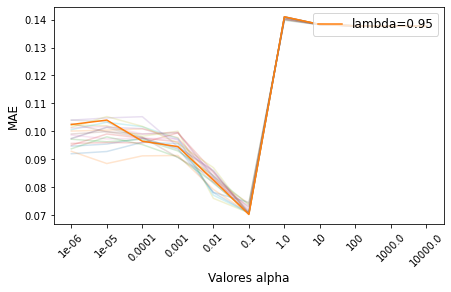

In [6]:
l_alpha = [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1.0, 10, 100, 1e+3, 1e+4, 1e+5]
res0 = comp2_K3.cv_results_['mean_test_score'][lw0]
plt.figure( figsize=(7,4))
print('best_alpha = %.6f' % comp2_K3.best_params_['regressor__mlp__l2'])
print('best_lw = %.6f' % comp2_K3.best_params_['regressor__mlp__lw'])
print('best_cv_mae = %.6f' % (comp2_K3.best_score_))
plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
plt.xlabel('Valores alpha', fontsize=12)
plt.ylabel("MAE", fontsize=12)
plt.plot(-res0, alpha=0.2)
plt.plot(-res1, alpha=0.2)
plt.plot(-res2, alpha=0.2)
plt.plot(-res3, alpha=0.2)
plt.plot(-res4, alpha=0.2)
plt.plot(-res5, alpha=0.2)
plt.plot(-res6, alpha=0.2)
plt.plot(-res7, alpha=0.2)
plt.plot(-res8, alpha=0.2)
plt.plot(-res9, alpha=0.2)
plt.plot(-res10, alpha=0.2)
plt.plot(-res11, alpha=0.2)
plt.plot(-res12, alpha=0.2)
plt.plot(-res13, alpha=0.2)
plt.plot(-res14, alpha=0.2)
plt.plot(-res15, alpha=0.2)
plt.plot(-res16, alpha=0.2)
plt.plot(-res17, alpha=0.2)
plt.plot(-res18, alpha=0.2)
plt.plot(-res19, label = "lambda=0.95", color='C1')
plt.legend(loc=1, prop={'size': 12})
plt.savefig('comp2_wrap_K3_param.png', bbox_inches = 'tight')
plt.show()


## Escenario K=4

In [17]:

def rejilla(dataset):
    coordenadas = ["(43.625, -8.125)","(43.625, -8.0)","(43.625, -7.875)","(43.625, -7.75)","(43.625, -7.625)",
               "(43.5, -8.125)","(43.5, -8.0)","(43.5, -7.875)","(43.5, -7.75)","(43.5, -7.625)",
               "(43.375, -8.125)","(43.375, -8.0)","(43.375, -7.875)","(43.375, -7.75)","(43.375, -7.625)",
               "(43.25, -8.125)","(43.25, -8.0)","(43.25, -7.875)","(43.25, -7.75)","(43.25, -7.625)",
               "(43.125, -8.125)","(43.125, -8.0)","(43.125, -7.875)","(43.125, -7.75)","(43.125, -7.625)"]
    variables = ["10u_", "10v_", "2t_", "sp_", "100u_", "100v_", "vel10_", "vel100_"]
    
    indices = []
    for var in variables:
        for coord in coordenadas:
            indices.append(str(var) + str(coord))
    return(dataset[indices])
    
def fisher_y(y):
    """ y_ij = (n-n_j)/(n*sqrt(n_j)) if class(y_i)==j else -sqrt(n_j)/n """
    n = len(y)
    targets, counts = np.unique(y, return_counts=True)
    c = len(targets)
    lsrlda_y = np.zeros((n, c))
    for i, target in enumerate(y):
        t = targets.tolist().index(target)
        for j in range(c):
            if j==t:
                lsrlda_y[i, j] = (n - counts[t]) / (n * np.sqrt(counts[t]))
            else:
                lsrlda_y[i, j] = -np.sqrt(counts[t]/n)
    return lsrlda_y
    
def network(l2, lw):
    """
    Builds functional MLP Keras model for companion categorical_crossentropy and mse losses,
    softmax and linear outputs respectively, relu activations, adam solver.
    
    ### Arguments:
        input_shape: feature dimension
        output_shape: target dimension
        hidden_layer_sizes: list with number of units on hidden layers
        regr_loss: regression loss; mse or mean_absolute_error
        alpha: parameter for l2 kernel regularizers for all layers
        
    ### Returns:
        model: Model
    """
    set_seed(123)
    input_layer = Input(shape=(200,),name = "input_layer")
    layer_1 = Dense(200, activation="relu", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'layer_1')(input_layer)
    layer_2 = Dense(100, activation="relu", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'layer_2')(layer_1)
    regr_layer = Dense(1, activation="linear", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'regr_layer')(layer_2)
    clas_layer = Dense(4, activation="linear", kernel_initializer = 'glorot_uniform', kernel_regularizer=regularizers.l2(l2), name = 'clas_layer')(layer_2)
    ##Defining the model by specifying the input and output layers
    network_ = Model(inputs=[input_layer], outputs=[regr_layer, clas_layer])
    ## defining the optimiser and loss function
    network_.compile(optimizer='adam',
                   loss={'regr_layer':'mse','clas_layer': 'mse'},
                   loss_weights= {"regr_layer":1.0, "clas_layer": lw},
                   metrics = {'regr_layer':'mae', "clas_layer": 'accuracy'})
    return(network_)

class PartialMinMaxScaler(MinMaxScaler):
    """Applies the scaler in super() to the first column of the 
    numpy array to be scaled,
    """
    def fit(self, x):
        super().fit(x[ : , 0].reshape(-1, 1))
        
    def transform(self, x):
        xx = x.copy()
        xx_0 = super().transform(x[ : , 0].reshape(-1, 1))
        xx[ : , 0] = xx_0.reshape(-1, )
        return xx
        
    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)
    def inverse_transform(self, x):
        xx = x.copy()
        x_0 = super().inverse_transform(x[ : , 0].reshape(-1, 1))
        xx[ : , 0] = x_0.reshape(-1, )
        return xx

def fc_mae(y, y_pred, **kwargs):
    return -mean_absolute_error(y[ : , 0], y_pred) 

class CompanionWrapper(BaseWrapper):
    """
    Predictions made on the RR outputs.
    """
    def __init__(self, model = network, **sk_params):
        BaseWrapper.__init__(self, model=model, **sk_params)
    def fit(self, x, y, **kwargs):
        """
        Assumes class codings as consecutive labels 0, 1, ...
        """        
        es = keras.callbacks.EarlyStopping(monitor="loss",
                                            min_delta=1.e-8,
                                            patience=50,
                                            verbose=0,
                                            mode="auto",
                                            baseline=None,
                                            restore_best_weights=True,
                                            )
        
        y_regr = y[:,0]
        y_clas = y[:,1]
        fishery = fisher_y(y_clas)
        
        self.X_dtype_ = type(x)
        self.X_shape_ = x.shape
        
        self.history_ = BaseWrapper.fit(self, x,
                                        {'regr_layer':y_regr,'clas_layer':fishery},
                                        epochs = self.epochs, initial_epoch = 0, shuffle=False,
                                       callbacks = [es])

        return self.history_

    # Convertir la salida a rango [5,50.000] respetando el contexto.
    def predict(self, x, **kwargs):
        """
        We just drop the mse predictions of the model and keep the CE ones
        in the first returned list.
        """
        pred = BaseWrapper.predict(self, x)[0]
        return np.clip(pred, a_min = 0, a_max = 1)
    
    def score(self, x, y):
        y_pred = BaseWrapper.predict(self, x)[0]
        y_pred = np.clip(y_pred, a_min = 0, a_max = 1)
        return mean_absolute_error(y[:,0], y_pred)

def sotavento_data():
    sota2016 = pd.read_csv("data/data_target_stv_2016.csv", sep = ',',  encoding = "ISO-8859-1", index_col=0, parse_dates=True).dropna()
    sota2017 = pd.read_csv("data/data_target_stv_2017.csv", sep = ',',  encoding = "ISO-8859-1", index_col=0, parse_dates=True).dropna()
    test = pd.read_csv("data/data_target_stv_2018.csv", sep = ',',  encoding = "ISO-8859-1", index_col=0, parse_dates=True).dropna()
    train = sota2016.append(sota2017)
    y_train = train[['targ']].to_numpy()
    x_train = rejilla(train.drop(columns = ['targ'])).to_numpy()
    y_test = test[['targ']].to_numpy()
    x_test = rejilla(test.drop(columns = ['targ'])).to_numpy()
    return(x_train,y_train,x_test,y_test)


def set_seed(seed):

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    os.environ['PYTHONHASHSEED'] = str(seed)
    python_random.seed(seed)
    tensorflow.random.set_seed(seed)
    np.random.seed(seed)

## Ajuste de hiperparámetros

In [18]:
comp2_K4 = load('comp_wrap2_K4.joblib')

In [19]:
lw0 = []
lw1 = []
lw2 = []
lw3 = []
lw4 = []
lw5 = []
lw6 = []
lw7 = []
lw8 = []
lw9 = []
lw10 = []
lw11 = []
lw12 = []
lw13 = []
lw14 = []
lw15 = []
lw16 = []
lw17 = []
lw18 = []
lw19 = []
for i in range(0,220):
    if i % 20==0:
        lw0.append(i)
    elif i % 20==1:
        lw1.append(i)
    elif i % 20==2:
        lw2.append(i)
    elif i % 20==3:
        lw3.append(i)
    elif i % 20==4:
        lw4.append(i)
    elif i % 20==5:
        lw5.append(i)
    elif i % 20==6:
        lw6.append(i)
    elif i % 20==7:
        lw7.append(i)
    elif i % 20==8:
        lw8.append(i)
    elif i % 20==9:
        lw9.append(i)
    if i % 20==10:
        lw10.append(i)
    elif i % 20==11:
        lw11.append(i)
    elif i % 20==12:
        lw12.append(i)
    elif i % 20==13:
        lw13.append(i)
    elif i % 20==14:
        lw14.append(i)
    elif i % 20==15:
        lw15.append(i)
    elif i % 20==16:
        lw16.append(i)
    elif i % 20==17:
        lw17.append(i)
    elif i % 20==18:
        lw18.append(i)
    elif i % 20==19:
        lw19.append(i)
        
res0 = comp2_K4.cv_results_['mean_test_score'][lw0]
res1 = comp2_K4.cv_results_['mean_test_score'][lw1]
res2 = comp2_K4.cv_results_['mean_test_score'][lw2]
res3 = comp2_K4.cv_results_['mean_test_score'][lw3]
res4 = comp2_K4.cv_results_['mean_test_score'][lw4]
res5 = comp2_K4.cv_results_['mean_test_score'][lw5]
res6 = comp2_K4.cv_results_['mean_test_score'][lw6]
res7 = comp2_K4.cv_results_['mean_test_score'][lw7]
res8 = comp2_K4.cv_results_['mean_test_score'][lw8]
res9 = comp2_K4.cv_results_['mean_test_score'][lw9]
res10 = comp2_K4.cv_results_['mean_test_score'][lw10]
res11 = comp2_K4.cv_results_['mean_test_score'][lw11]
res12 = comp2_K4.cv_results_['mean_test_score'][lw12]
res13 = comp2_K4.cv_results_['mean_test_score'][lw13]
res14 = comp2_K4.cv_results_['mean_test_score'][lw14]
res15 = comp2_K4.cv_results_['mean_test_score'][lw15]
res16 = comp2_K4.cv_results_['mean_test_score'][lw16]
res17 = comp2_K4.cv_results_['mean_test_score'][lw17]
res18 = comp2_K4.cv_results_['mean_test_score'][lw18]
res19 = comp2_K4.cv_results_['mean_test_score'][lw19]

best_alpha = 0.100000
best_lw = 0.9500
best_cv_mae = -0.070


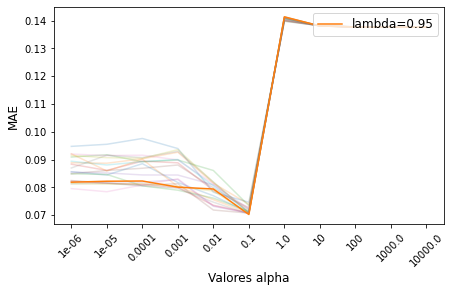

In [20]:
l_alpha = [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1.0, 10, 100, 1e+3, 1e+4, 1e+5]
res0 = comp2_K4.cv_results_['mean_test_score'][lw0]
plt.figure( figsize=(7,4))
print('best_alpha = %.6f' % comp2_K4.best_params_['regressor__mlp__l2'])
print('best_lw = %.4f' % comp2_K4.best_params_['regressor__mlp__lw'])
print('best_cv_mae = %.3f' % (comp2_K4.best_score_))
plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
plt.xlabel('Valores alpha', fontsize=12)
plt.ylabel("MAE", fontsize=12)
plt.plot(-res0, alpha=0.2)
plt.plot(-res1, alpha=0.2)
plt.plot(-res2, alpha=0.2)
plt.plot(-res3, alpha=0.2)
plt.plot(-res4, alpha=0.2)
plt.plot(-res5, alpha=0.2)
plt.plot(-res6, alpha=0.2)
plt.plot(-res7, alpha=0.2)
plt.plot(-res8, alpha=0.2)
plt.plot(-res9, alpha=0.2)
plt.plot(-res10, alpha=0.2)
plt.plot(-res11, alpha=0.2)
plt.plot(-res12, alpha=0.2)
plt.plot(-res13, alpha=0.2)
plt.plot(-res14, alpha=0.2)
plt.plot(-res15, alpha=0.2)
plt.plot(-res16, alpha=0.2)
plt.plot(-res17, alpha=0.2)
plt.plot(-res18, alpha=0.2)
plt.plot(-res19, label = "lambda=0.95", color='C1')
plt.legend(loc=1, prop={'size': 12})
plt.savefig('comp2_wrap_K4_param.png', bbox_inches = 'tight')
plt.show()
